# Livrable 1 - Classification multiclasse

## Contexte


L'entreprise TouNum travaille sur la numérisation de documents (textes, images...). Leurs services sont souvent requis par des entreprises numérisant leur base de documents papier. Ils souhaitent étendre leur gamme de services pour inclure des outils de Machine Learning. En effet, certains de leurs clients ont une grande quantité de données à numériser, et un service de catégorisation automatique serait plus que valorisable.
TouNum n'a pas dans son personnel de spécialiste du Machine Learning. L'entreprise fait alors appel à nous, les spécialistes en Data Science de CESI. On nous propose un premier contrat pour travailler sur une solution visant à analyser des photographies pour en déterminer une légende descriptive de manière automatique (du captioning).

L'entreprise voulant automatiser la sélection de photos pour l'annotations, ce livrable présente une méthode de classification se basant sur les réseaux de neurones afin de filtrer les images qui ne sont pas des photos.

## Introduction


Dans le domaine de l'annotation d'images, l'automatisation de la sélection de photos au sein de datasets complexes constitue un défi significatif. La diversité des images, qu'elles soient des peintures, des schémas, des portraits dessinés, des images de textes scannés, ou des photographies, nécessite une approche intelligente pour identifier spécifiquement les photographies parmi cette variété.

Ce notebook Jupyter explore une solution basée sur les réseaux de neurones pour automatiser cette tâche de distinction. L'objectif final est de créer un modèle capable de classifier les images et de filtrer celles qui ne sont pas des photographies. Pour ce faire, nous utiliserons des techniques avancées de deep learning, en mettant particulièrement l'accent sur l'architecture de réseaux de neurones convolutifs (CNN).

Ce projet s'appuie sur plusieurs datasets, chacun présentant ses propres défis. Les images, bien que non étiquetées, sont réparties dans des archives différentes, offrant ainsi une opportunité d'exploration et de classification diversifiée.

Au cours de ce notebook, nous détaillerons le choix de l'architecture du réseau de neurones, les paramètres spécifiques du modèle, la fonction de perte, et l'algorithme d'optimisation utilisé pour l'entraînement. Nous suivrons ensuite le processus d'entraînement du modèle sur les données, l'évaluation de sa performance, et enfin, nous explorerons des techniques de régularisation pour améliorer le compromis entre biais et variance.

La méthodologie adoptée sera présentée à travers un notebook interactif, permettant une compréhension approfondie du processus. L'objectif final de ce travail est de fournir une solution robuste et précise pour automatiser la sélection de photos dans des datasets variés, facilitant ainsi le travail d'annotation et d'analyse visuelle au sein de votre équipe.

Afin de garantir une évolutivité optimale dans l'éventualité d'une évolution du besoin, nous avons décidé de ne pas limiter notre modèle de classification à une claissification binaire. Nous avons alor implémenté une classification multiclasse permettant de faire évoluer les réponses de notre modèle en identifiant précisément la classe à laquelle appartient une image, au lieu de simplement renseigner si il s'agit ou non d'une photo.

## Configuration de l'environnement


Avant de commencer le traitement et l'analyse des images, il est essentiel de configurer correctement l'environnement de travail. Cette configuration implique l'installation et l'importation des bibliothèques nécessaires pour mener à bien le projet. Ces bibliothèques fournissent les outils et fonctions nécessaires pour manipuler les images, construire et entraîner des modèles d'apprentissage automatique, et visualiser les résultats.

### Installation des dépendances

In [ ]:
#!pip install pandas matplotlib Pillow scikit-learn seaborn opencv-python keras-tuner
#!pip install tensorflow[and-cuda]

### Importation des bibliothèques

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os


from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from PIL import Image, UnidentifiedImageError

import random
from tensorflow import data as tf_data
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, BatchNormalization, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns


from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import *
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense

from tensorflow.keras.models import Model

from tensorflow.python.keras.layers import Dense, Flatten
import keras_tuner as kt

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.initializers import GlorotUniform, HeNormal
import datetime
from tensorflow.keras.callbacks import TensorBoard

import pandas as pd

2024-01-08 02:27:20.612678: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-08 02:27:20.612737: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-08 02:27:20.646704: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 02:27:20.725948: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-08 02:27:21.716514: W tensorflow/compiler/tf2

### Vérification des GPUs

In [ ]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.15.0
Num GPUs Available:  1


2024-01-08 02:27:24.053294: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-08 02:27:24.210287: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-08 02:27:24.210340: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.


### Configuration des Paramètres Généraux

**IMG_SIZE** (Taille de l'image) :

Représente la hauteur et la largeur en pixels à laquelle toutes les images de l'ensemble de données seront redimensionnées. Dans notre cas, chaque image sera redimensionnée en une image carrée de 150x150 pixels. Un choix de taille plus élevé peut améliorer la qualité des détails capturés par le modèle mais peut augmenter significativement la charge de calcul. Inversement, une taille trop réduite peut entraîner une perte d'informations visuelles importantes.


**CHANNELS** :

Indique le nombre de canaux de couleur dans nos images. Pour les images RGB (Rouge, Vert, Bleu), la valeur est 3. Si nos images étaient en niveaux de gris, cette valeur serait 1. Nous avons décidé d'utilise 3 channels car les images en couleur offrent plus d'informations (mais elles augmentent aussi la complexité du modèle et les ressources nécessaires pour le traitement et l'apprentissage.)


**BATCH_SIZE** (Taille du lot) :

Le BATCH_SIZE Détermine combien d'échantillons d'entraînement sont passés à travers le réseau avant de mettre à jour les poids. Une valeur de 32 signifie que 32 images sont traitées en un seul lot.
Des lots plus grands peuvent réduire le temps d'entraînement et stabiliser l'apprentissage, mais peuvent également augmenter les exigences en mémoire. Des lots plus petits offrent un apprentissage plus fin, mais peuvent être plus instables et lents.


**EPOCHS** (Époques) :

Le nombre total de passages à travers l'ensemble de données complet pendant l'entraînement. Avec 15 époques, l'ensemble de données sera parcouru 15 fois.
Considérations supplémentaires : Plus d'époques permettent potentiellement au modèle de mieux apprendre, mais entraine le risque de sur-entraîner le modèle (overfitting), où il apprend trop spécifiquement sur les données d'entraînement et performe mal sur les données inédites.


**LEARNING_RATE** (Taux d'apprentissage) :

Le LEARNING_RATE détermine la taille des pas lors de la mise à jour des poids. Un taux de 0.001 est souvent un bon point de départ pour de nombreux modèles.
Considérations supplémentaires : un taux d'apprentissage trop élevé peut conduire à un apprentissage instable, tandis qu'un taux trop faible rend l'apprentissage extrêmement lent et peut se coincer dans des minima locaux.




In [ ]:
# Configuration de paramètres
IMG_SIZE = 256 # @param {type:"number"}
CHANNELS = 3 # @param {type:"integer"}
BATCH_SIZE = 64 # @param {type:"integer"}
EPOCHS = 50 # @param {type:"integer"}
LEARNING_RATE = 0.001 # @param {type:"number"}
NUM_CLASSES = 5
WORKERS = 11

## Chargement des données






### Configuration et chargement des données



**Définition des sources de données**
Selon l'environnement d'exécution, le code ajuste la source des données :

- **Environnement Local** : Le chemin vers le dossier contenant les données est spécifié manuellement.
- **Google Colab** : Les données sont chargées depuis Google Drive.


In [ ]:
local = True # @param {type:"boolean"}
name_categories = ["Photo","Schematics","Sketch","Text","Painting"]


if local :
  data_dir = "/mnt/f/Projet_Data/Option-DaTA"
  models_save_dir = '/mnt/f/Projet_Data/Option-DaTA/models'
  if not os.path.exists(models_save_dir):
    os.makedirs(models_save_dir)
else :
  from google.colab import drive
  drive.mount('/content/drive')
  data_dir = '/content/Option-DaTA'
  models_save_dir = '/content/model/'
  if not os.path.exists(models_save_dir):
    os.makedirs(models_save_dir)

  if os.path.exists(data_dir) :
    os.system(f"rm -rf {data_dir}")
  !gdown https://drive.google.com/uc?id=17gszVPR5LQY-ewtwvGUsC_8zD7i0SjJg
  !unzip Option-DaTA.zip


Copie des fichiers sur le disque de Colab afin de réduire les temps d'éxecution

### Suppression et décompression des Données (si nécessaire)


Pour garantir que les données sont à jour, le code offre la possibilité de supprimer et de décompresser à nouveau les datasets.

In [ ]:
rm_modifer_img = False # @param {type:"boolean"}
unzip_dataset = False # @param {type:"boolean"}

# Suppression des images modifiées
if rm_modifer_img and local:
    os.system(f"rm -rf {os.path.join(data_dir, 'modifier')}")

# Décompression des datasets
if unzip_dataset:
    # Liste des noms de fichier zip à décompresser
    zip_files = ['Schematics.zip', 'Sketch.zip', 'Text.zip', 'Photo.zip', 'Painting.zip']
    for zip_file in zip_files:
        os.system(f"unzip -d {data_dir} /content/drive/MyDrive/Dataset-Option-Data/{zip_file}")


### Chargement des images dans les ImageDataGenerator

Cette section du notebook décrit la création de générateurs de données pour l'entraînement, la validation et les tests. Ces générateurs sont configurés pour charger et transformer les images des dossiers spécifiés de manière appropriée avant de les fournir au modèle pendant l'entraînement ou l'évaluation. La configuration utilise **ImageDataGenerator** de Keras, avec des paramètres tels que **rescale**, **horizontal_flip**, **zoom_range**, et **fill_mode**. Les générateurs sont créés avec **flow_from_directory**, spécifiant le chemin, la taille de l'image, la taille du lot, le mode couleur, le mode de classe et le mélange. Des exemples montrent que les images sont chargées de différents répertoires avec des configurations spécifiques pour l'entraînement, la validation et les tests.

Ce code crée des générateurs de données pour l'entraînement et la validation. Ce code configure les générateurs pour l'entraînement et la validation. Ils chargeront les images à partir des dossiers spécifiés, les transformeront de manière appropriée, et les fourniront au modèle pendant l'entraînement ou l'évaluation.

In [ ]:
# Initialisation du générateur de données pour l'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalisation des pixels à des valeurs entre 0 et 1
    horizontal_flip=True,  # Retournement horizontal aléatoire des images
    zoom_range=0.15,  # Application d'un zoom aléatoire jusqu'à 15%
    fill_mode='nearest'  # Remplissage des pixels manquants après transformation
)

# Création du générateur d'images pour l'entraînement
train_generator = train_datagen.flow_from_directory(
    os.path.join(data_dir, "Dataset1_train"),  # Chemin vers le dossier d'entraînement
    target_size=(IMG_SIZE, IMG_SIZE),  # Taille cible pour les images
    batch_size=BATCH_SIZE,  # Taille du lot
    color_mode='rgb',  # Mode de couleur des images
    class_mode='categorical',  # Mode de classification (multiclasse)
    shuffle=True  # Mélange des données pour l'entraînement
)

# Initialisation du générateur de données pour la validation
val_datagen = ImageDataGenerator(
    rescale=1./255  # Normalisation des pixels (sans augmentation de données)
)

# Création du générateur d'images pour la validation
validation_generator = val_datagen.flow_from_directory(
    os.path.join(data_dir, "Dataset1_val"),  # Chemin vers le dossier de validation
    target_size=(IMG_SIZE, IMG_SIZE),  # Taille cible pour les images
    batch_size=BATCH_SIZE,  # Taille du lot
    color_mode='rgb',  # Mode de couleur des images
    class_mode='categorical',  # Mode de classification (multiclasse)
    shuffle=False  # Pas de mélange pour les données de validation
)


Found 37501 images belonging to 5 classes.
Found 10000 images belonging to 5 classes.


In [ ]:
# Initialisation du générateur de données, sans augmentation, pour le test
datagen = ImageDataGenerator(
    rescale=1./255  # Normalisation des pixels à des valeurs entre 0 et 1
)

# Création du générateur d'images pour l'ensemble de test
test_generator = datagen.flow_from_directory(
    os.path.join(data_dir, "Dataset1_test"),  # Chemin vers le dossier de test
    target_size=(IMG_SIZE, IMG_SIZE),  # Taille cible pour les images
    batch_size=BATCH_SIZE,  # Taille du lot
    color_mode='rgb',  # Mode de couleur des images (RGB)
    class_mode='categorical',  # Mode de classification (multiclasse)
    shuffle=False  # Pas de mélange pour les données de test
)


Found 2500 images belonging to 5 classes.


In [ ]:
try:
    # Essaie de récupérer le prochain lot d'images depuis le générateur d'entraînement
    batch_images, _ = next(train_generator)
    # Affiche la forme du lot récupéré, indiquant le nombre d'images et leurs dimensions
    print("Batch shape:", batch_images.shape)
except StopIteration:
    # Si le générateur n'a plus de données à fournir ou rencontre un problème, affiche un message d'erreur
    print("Le générateur est épuisé ou ne fournit pas de données.")


Batch shape: (64, 256, 256, 3)


In [ ]:
# Crée un dictionnaire inversé à partir de `class_indices` du générateur
# Cela permet de mapper les indices numériques aux noms de classe
labels = {value: key for key, value in train_generator.class_indices.items()}

# Affiche les mappages de label pour faciliter l'identification des classes
print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    # Pour chaque paire clé-valeur dans le dictionnaire, affiche l'indice de la classe et son nom correspondant
    print(f"{key} : {value}")


Label Mappings for classes present in the training and validation datasets

0 : Painting
1 : Photo
2 : Schematics
3 : Sketch
4 : Text


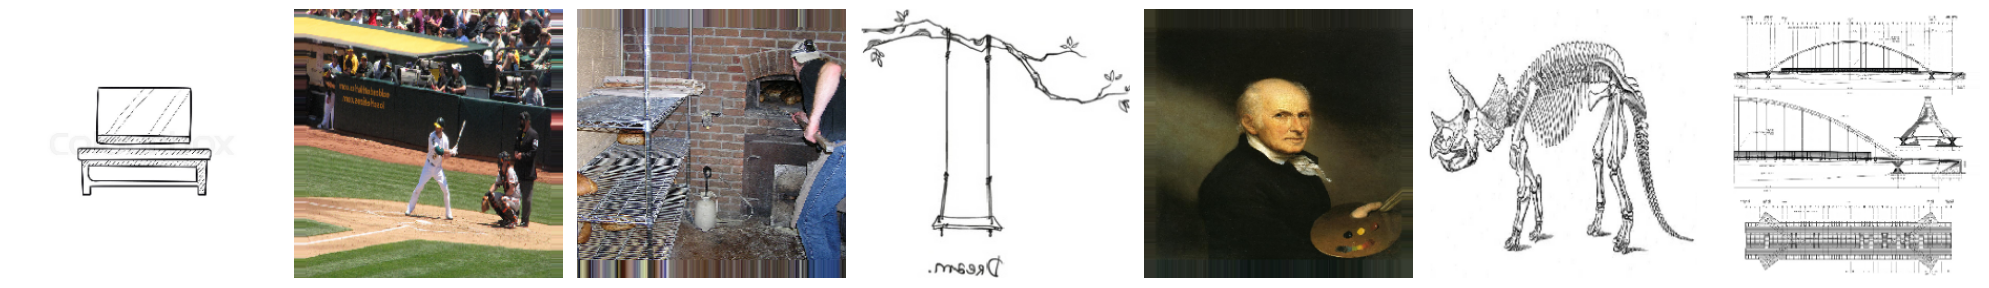

In [ ]:
def display_images_from_generator(generator, num_images=5, figsize=(20, 20)):
    """
    Affiche un nombre spécifié d'images extraites d'un générateur de données.
    Args:
    - generator: le générateur de données d'images.
    - num_images: le nombre d'images à afficher.
    - figsize: la taille de la figure pour matplotlib.
    """
    plt.figure(figsize=figsize)

    for i in range(num_images):
        try:
            # Obtenir un batch d'images
            images, _ = next(generator)
            # Afficher la première image du batch
            plt.subplot(1, num_images, i + 1)
            plt.imshow(images[0])
            plt.axis('off')
        except StopIteration:
            # Le générateur n'a plus de données
            print(f"Le générateur est épuisé après {i} images.")
            break

    plt.tight_layout()
    plt.show()

# Appel de la fonction pour afficher 7 images du train_generator
display_images_from_generator(train_generator, num_images=7)


## Visualisation des résultats de l'entraînement

Cette section du notebook se concentre sur l'analyse des performances du modèle de classification d'images après l'entraînement. Elle utilise des graphiques pour afficher la précision (accuracy) et la perte (loss) sur les ensembles d'entraînement et de validation au fil des époques. Cela permet de visualiser l'évolution de la performance du modèle pendant l'entraînement, y compris l'ajustement de la précision et la réduction de la perte, aidant à identifier des problèmes comme le surajustement (overfitting). La section inclut également des graphiques sur l'évolution du taux d'apprentissage, des prédictions sur l'ensemble de test, et une matrice de confusion pour une analyse détaillée des performances de classification.

Fonction visualisation_data : Visualise les performances d'un modèle de classification d'images.

In [ ]:
def visualisation_data(history, model):

    # Récupération de la précision (accuracy) et de la perte (loss) pour les ensembles d'entraînement et de validation
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Création d'une plage de valeurs pour les époques
    epochs_range = range(1, len(history.history['accuracy']) + 1)

    # Affichage de la précision pour chaque époque
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)  # Création d'une sous-figure pour la précision
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Affichage de la perte pour chaque époque
    plt.subplot(1, 2, 2)  # Création d'une sous-figure pour la perte
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # Vérifiez si 'lr' est dans l'historique
    if 'lr' in history.history:
        plt.plot(history.history['lr'], label='Training Learning Rate')
        plt.title('Learning Rate vs. Epochs')
        plt.ylabel('Learning Rate')
        plt.xlabel('Epoch')
        plt.legend(loc='upper right')
        plt.show()

    # Prédiction sur l'ensemble de test
    predictions = model.predict(test_generator)

    # Affichage des prédictions sur un sous-ensemble d'images de test
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
    idx = 0
    for i in range(2):
        for j in range(5):
            predicted_label = labels[np.argmax(predictions[idx])]
            ax[i, j].set_title(f"{predicted_label}")
            ax[i, j].imshow(test_generator[0][0][idx])
            ax[i, j].axis("off")
            idx += 1
    plt.tight_layout()
    plt.suptitle("Test Dataset Predictions", fontsize=20)

    # Calcul de la matrice de confusion
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes
    cf_mtx = confusion_matrix(y_true, y_pred)

    # Formatage et affichage de la matrice de confusion
    group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
    box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf_mtx.shape[0], cf_mtx.shape[1])
    plt.figure(figsize = (12, 10))
    sns.heatmap(cf_mtx, annot=box_labels, fmt="", cmap="YlGnBu")
    plt.xlabel('Predicted Classes')
    plt.ylabel('True Classes')
    plt.show()

    # Affichage du rapport de classification
    print(classification_report(y_true, y_pred, target_names=labels.values()))

## Création et optimisation des hyperparamètres de modèles
Cette section du notebook détaille la construction d'un modèle de classification d'images en utilisant Keras Tuner pour l'optimisation des hyperparamètres. Le processus inclut la configuration de divers paramètres comme le nombre de couches convolutionnelles, la taille des filtres, le nombre de neurones dans les couches denses, et le choix de l'activation et de l'initialisation des poids. L'optimisation utilise également différents optimiseurs comme Adam, SGD, et RMSprop avec des taux d'apprentissage variables. Le Keras Tuner effectue un nombre défini d'essais pour trouver la meilleure combinaison d'hyperparamètres, basée sur la précision de validation. Le modèle final est sauvegardé après cette optimisation.


In [ ]:

# EarlyStopping pour arrêter l'entraînement si aucune amélioration n'est observée
early_stopping = EarlyStopping(
    monitor='val_loss',  # Surveillance de la perte de validation
    patience=5,  # Nombre d'époques sans amélioration avant l'arrêt
    restore_best_weights=True  # Restauration des meilleurs poids à la fin
)

# ReduceLROnPlateau pour réduire le taux d'apprentissage si aucune amélioration n'est observée
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Surveillance de la perte de validation
    factor=np.sqrt(0.01),  # Facteur de réduction du taux d'apprentissage
    patience=5  # Nombre d'époques sans amélioration avant la réduction
)
# Chemin du répertoire où les logs seront stockés
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Créer une instance de TensorBoard
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [ ]:
def build_model(hp):

  model = Sequential()

  # Optimisation du nombre de couches convolutives
  for i in range(hp.Int('num_conv_layers', 2, 4)):
      # Optimisation de la taille du filtre et du stride pour chaque couche
      filter_size = hp.Choice(f'filter_size_layer_{i}', [3, 5])
      stride = hp.Choice(f'stride_layer_{i}', [1, 2])

      # Ajout d'une couche convolutive
      model.add(Conv2D(filters=hp.Int(f'filters_layer_{i}', 32, 128, step=32),
                      kernel_size=filter_size,
                      strides=stride,
                      padding='same',
                      kernel_initializer=hp.Choice('kernel_initializer', ['GlorotUniform', 'HeNormal']),
                      input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS)))
      # Ajout d'une couche d'activation
      model.add(Activation(hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])))
      # Ajout d'une couche de pooling et de normalisation
      model.add(MaxPooling2D(pool_size=(2, 2)))
      model.add(BatchNormalization())

  # Ajout d'une couche pour aplatir les données avant la couche dense
  model.add(Flatten())

  # Ajout d'une couche dense optimisée
  model.add(Dense(units=hp.Int('units_dense_layer', min_value=256, max_value=1024, step=128),
                  activation=hp.Choice('dense_activation', ['relu', 'tanh', 'sigmoid']),
                  kernel_regularizer=l1_l2(l1=hp.Float('l1_reg', min_value=1e-6, max_value=1e-3, sampling='LOG'),
                                            l2=hp.Float('l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG'))))
  # Ajout d'une couche de Dropout pour réduire le surajustement
  model.add(Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
  # Ajout de la couche de sortie
  model.add(Dense(5, activation='softmax'))  # Ajustez le nombre de classes selon votre jeu de données

  # Optimisation de l'optimiseur
  optimizer_name = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
  learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')
  if optimizer_name == 'adam':
      optimizer = Adam(learning_rate=learning_rate)
  elif optimizer_name == 'sgd':
      optimizer = SGD(learning_rate=learning_rate)
  else:
      optimizer = RMSprop(learning_rate=learning_rate)

  # Compilation du modèle avec l'optimiseur et la fonction de perte
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

  return model


In [ ]:
# Initialisation de Keras Tuner avec l'optimisation bayésienne
tuner = kt.BayesianOptimization(
    build_model,  # Fonction pour construire le modèle
    objective='val_accuracy',  # Objectif d'optimisation : précision sur les données de validation
    max_trials=20,  # Nombre total d'essais pour trouver les meilleurs hyperparamètres
    num_initial_points=5,  # Nombre de points initiaux pour commencer l'exploration
    directory='my_dir',  # Répertoire pour enregistrer les résultats
    project_name='hparam_tuning_cnn_bayesian'  # Nom du projet
)

# Lancement de la recherche d'hyperparamètres
tuner.search(
    train_generator,  # Générateur de données d'entraînement
    epochs=EPOCHS,  # Nombre d'époques pour l'entraînement
    batch_size=BATCH_SIZE,  # Taille du lot
    validation_data=validation_generator,  # Générateur de données de validation
    callbacks=[early_stopping],  # Callback pour arrêter l'entraînement de manière anticipée
)


Reloading Tuner from my_dir/hparam_tuning_cnn_bayesian/tuner0.json


In [ ]:
# Récupérer le meilleur modèle à partir des résultats de l'optimisation par Keras Tuner

best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_model = tuner.hypermodel.build(best_hyperparameters)


2024-01-08 02:27:35.472635: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-08 02:27:35.472717: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-08 02:27:35.472759: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-08 02:27:35.859597: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-08 02:27:35.859654: I external/local_xla/xla/stream_executor

In [ ]:
# Affichage des hyperparamètres pour le meilleur essai
print("Best Hyperparameters:", best_hyperparameters.values)
# Affiche un résumé du modèle
# Construction du modèle avec les meilleurs hyperparamètres
model = build_model(best_hyperparameters)
model.summary()  # Résumé du modèle pour visualiser la structure et les paramètres

Best Hyperparameters: {'num_conv_layers': 4, 'filter_size_layer_0': 3, 'stride_layer_0': 2, 'filters_layer_0': 32, 'kernel_initializer': 'GlorotUniform', 'activation': 'sigmoid', 'filter_size_layer_1': 3, 'stride_layer_1': 2, 'filters_layer_1': 128, 'units_dense_layer': 896, 'dense_activation': 'tanh', 'l1_reg': 0.0009789187107379328, 'l2_reg': 0.0009110985015480359, 'dropout': 0.2, 'optimizer': 'sgd', 'learning_rate': 0.0009825313977391383, 'filter_size_layer_2': 5, 'stride_layer_2': 2, 'filters_layer_2': 128, 'filter_size_layer_3': 3, 'stride_layer_3': 1, 'filters_layer_3': 96}
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 activation_4 (Activation)   (None, 128, 128, 32)      0         
                                                             

In [ ]:


# Entraînement du modèle avec les données d'entraînement et de validation
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping,tensorboard_callback],
    workers=WORKERS,
    use_multiprocessing=True
)



40/40 [==============================] - 30s 746ms/step
Best Hyperparameters: {'num_conv_layers': 4, 'filter_size_layer_0': 3, 'stride_layer_0': 2, 'filters_layer_0': 32, 'kernel_initializer': 'GlorotUniform', 'activation': 'sigmoid', 'filter_size_layer_1': 3, 'stride_layer_1': 2, 'filters_layer_1': 128, 'units_dense_layer': 896, 'dense_activation': 'tanh', 'l1_reg': 0.0009789187107379328, 'l2_reg': 0.0009110985015480359, 'dropout': 0.2, 'optimizer': 'sgd', 'learning_rate': 0.0009825313977391383, 'filter_size_layer_2': 5, 'stride_layer_2': 2, 'filters_layer_2': 128, 'filter_size_layer_3': 3, 'stride_layer_3': 1, 'filters_layer_3': 96}


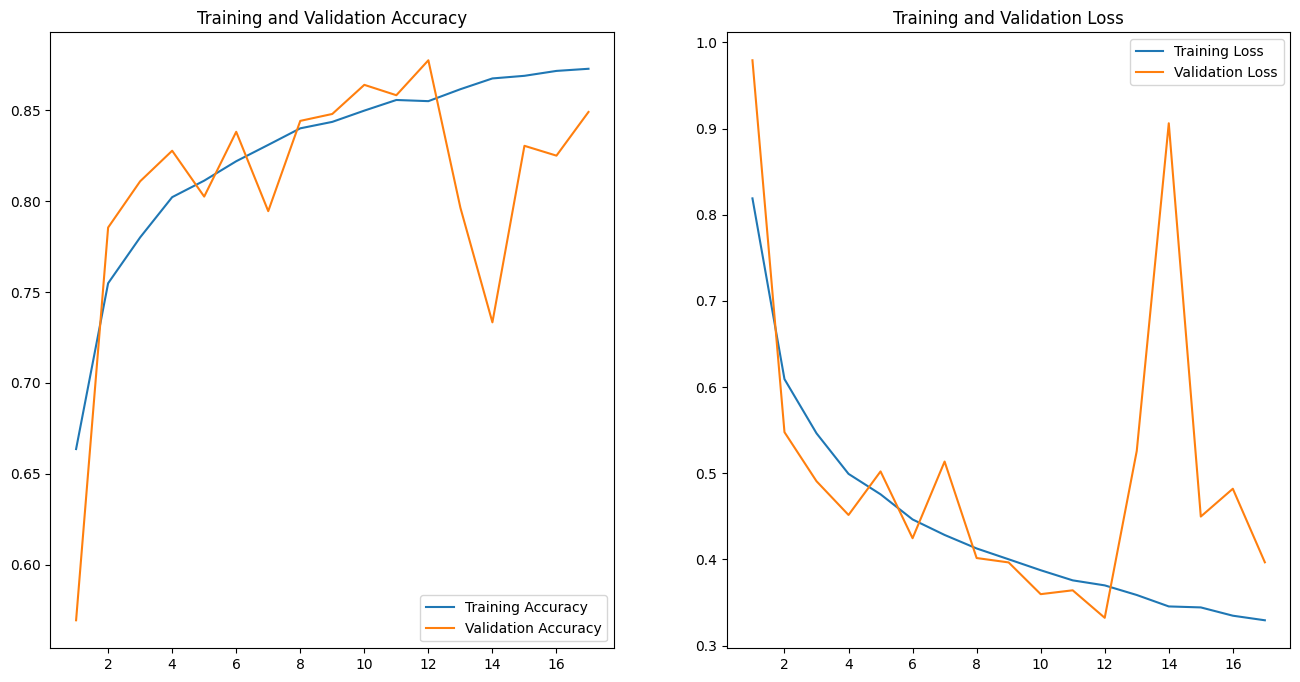

40/40 [==============================] - 18s 444ms/step


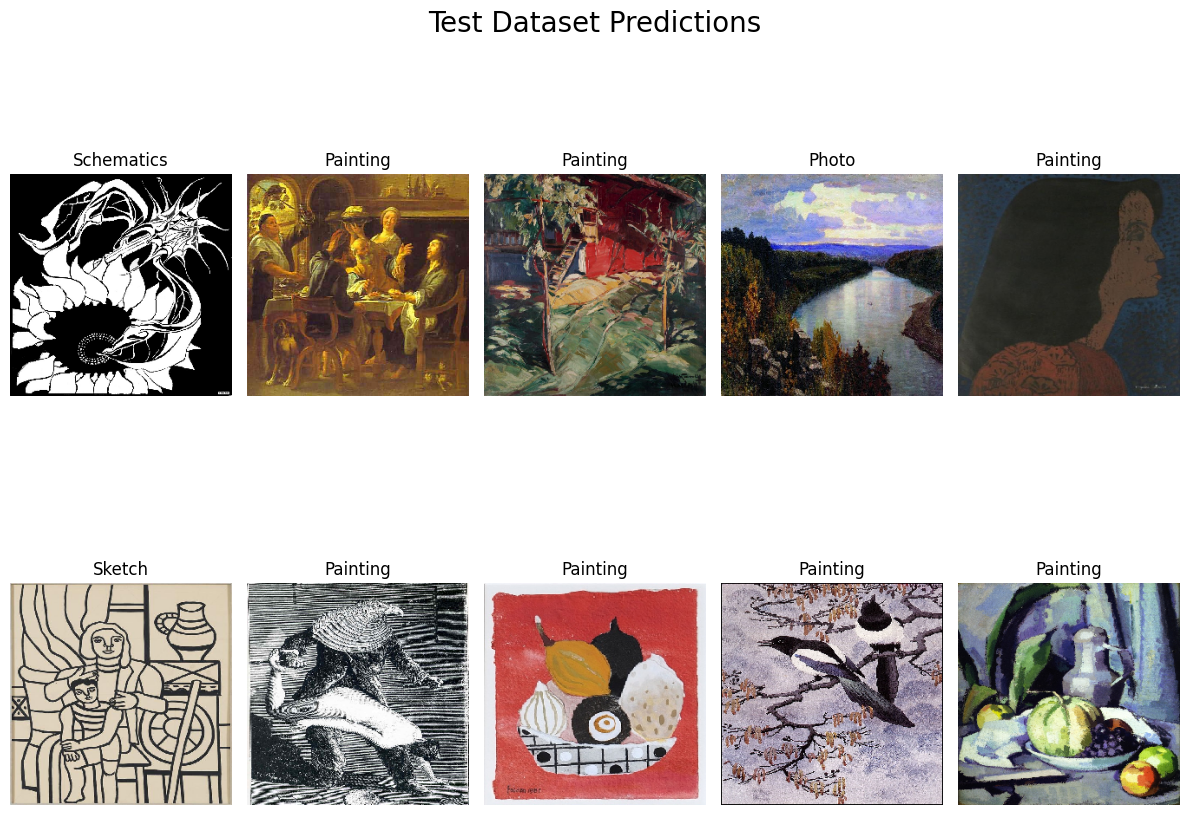

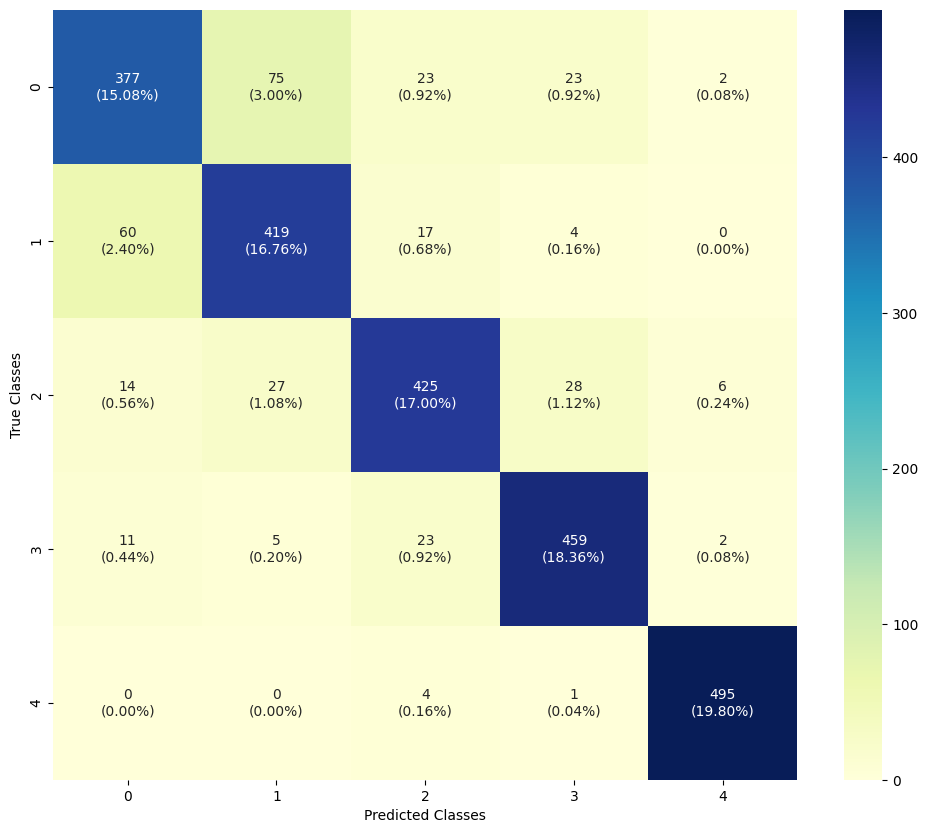

              precision    recall  f1-score   support

    Painting       0.82      0.75      0.78       500
       Photo       0.80      0.84      0.82       500
  Schematics       0.86      0.85      0.86       500
      Sketch       0.89      0.92      0.90       500
        Text       0.98      0.99      0.99       500

    accuracy                           0.87      2500
   macro avg       0.87      0.87      0.87      2500
weighted avg       0.87      0.87      0.87      2500



In [ ]:

# Prédiction sur l'ensemble de test et conversion en classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Affichage des hyperparamètres pour le meilleur essai
print("Best Hyperparameters:", best_hyperparameters.values)

# Optionnelle : Visualisation des données d'entraînement
visualisation_data(history, model)

In [ ]:
model_save_path = f"{models_save_dir}/best_model.h5"
model.save(models_save_dir)  # Sauvegarde le modèle au chemin spécifié
print(f"Saved model to {models_save_dir}")  # Affiche le chemin où le modèle a été sauvegardé

# Affiche un résumé du modèle
model.summary()  # Résumé du modèle pour visualiser la structure et les paramètres

INFO:tensorflow:Assets written to: /mnt/f/Projet_Data/Option-DaTA/models/assets


INFO:tensorflow:Assets written to: /mnt/f/Projet_Data/Option-DaTA/models/assets


Saved model to /mnt/f/Projet_Data/Option-DaTA/models
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 activation_4 (Activation)   (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_4 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       36992     
                                                                 
 

## Benchmark des meilleurs modèles de transfer learning

Cette section du notebook traite de l'évaluation comparative de divers modèles de transfert d'apprentissage populaires pour la tâche de classification d'images. Plusieurs architectures de réseaux de neurones convolutifs pré-entraînés, telles que ResNet, Inception, Xception, et EfficientNet, sont testées. Chaque modèle est adapté pour la classification spécifique en remplaçant les couches supérieures et en ajustant les poids pour le jeu de données en question. Les performances de chaque modèle sont évaluées en fonction de leur précision de validation, et les résultats sont comparés pour sélectionner le modèle le plus efficace pour la tâche donnée.

Paramètre de comfiguration et liste des models a benchmark

In [ ]:

# Liste des modèles de réseaux de neurones convolutifs à évaluer pour le benchmark
models_to_benchmark = [
    EfficientNetB7,  # Modèle EfficientNetB7
    Xception,        # Modèle Xception
    ResNet50,        # Modèle ResNet50
    ResNet152,       # Modèle ResNet152
    ResNet50V2,      # Modèle ResNet50V2
    ResNet101V2,     # Modèle ResNet101V2
    ResNet152V2,     # Modèle ResNet152V2
    InceptionV3,     # Modèle InceptionV3
    InceptionResNetV2  # Modèle InceptionResNetV2

]


In [ ]:
# Fonction pour créer un modèle avec option de plusieurs GPU
def create_transfer_learning_model(base_model_function, num_classes):

    base_model = base_model_function(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3), classes=5)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in base_model.layers:
        layer.trainable = False

    return model

def compile_and_train(model):
    # Compilation du modèle avec l'optimiseur Adam et la perte de catégorie croisée
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy'])

    # Entraînement du modèle avec des données et des callbacks spécifiques
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // BATCH_SIZE,
        callbacks=[early_stopping, reduce_lr,tensorboard_callback],  # Early stopping et réduction du taux d'apprentissage
        workers=WORKERS,  # Configuration pour l'utilisation de multiprocessing
        use_multiprocessing=True
    )
    return history


In [ ]:
benchmark_results = {}
for model_function in models_to_benchmark:
    # Affiche le nom du modèle en cours de benchmark
    print(f'Benchmarking {model_function.__name__}')

    # Crée un modèle de transfert d'apprentissage pour le modèle en cours
    model = create_transfer_learning_model(model_function, NUM_CLASSES)

    # Compile et entraîne le modèle, et récupère son historique
    history = compile_and_train(model)

    # Affiche les résultats et visualise les données de l'entraînement
    print(f'Resulta {model_function.__name__}')
    visualisation_data(history, model)

    # Stocke la meilleure précision de validation du modèle
    best_val_accuracy = max(history.history['val_accuracy'])
    benchmark_results[model_function.__name__] = best_val_accuracy

    # Sauvegarde le modèle entraîné
    model_save_path = f"{models_save_dir}/{model_function.__name__}_model.h5"
    model.save(model_save_path)
    print(f"Saved model to {model_save_path}")

# Affiche les résultats du benchmark
print("Résultats du Benchmark :")
for model_name, val_accuracy in benchmark_results.items():
    print(f"{model_name}: Meilleure précision de validation = {val_accuracy}")
